As a human being I* make decisions all the time. Luckily for me, I have a sophisticated neural network at my disposal to undertake the decision making process. Unfortunately, when it comes to educated judgment or to writing a program making those judgments, I need to work with exact numbers: evaluate them, infer and compare. 
To do this I need tools like Bayesian Inference and Markov Chain Monte Carlo to measure my prior and posterior beliefs. 
To teach myself about those tools, I'll calculate my prior belief given some knowledge on historical effectiveness of a facebook ad. I'll simulate running another ad and after I see different data I want to know how should my expectations about ads effectiveness should change, given the new data?


*there are proposed plot twists to this: https://en.wikipedia.org/wiki/Epiphenomenalism

I've used the following sources:

https://www.datascience.com/blog/introduction-to-bayesian-inference-learn-data-science-tutorials by Aaron Kramer

https://en.wikipedia.org/wiki/Metropolis-Hastings_algorithm

https://www.amazon.com/Probability-Theory-Science-T-Jaynes/dp/0521592712

## Imports and definitions

In [1]:
import matplotlib   # plotting 
import matplotlib.pyplot   # specific plotting
import matplotlib.animation as animation    # joining plots in animations
import matplotlib.patches as patches   # adding legends to matplotlib charts
from math import factorial, e, sqrt, pi
import numpy as np
from scipy.special import gamma
from scipy.stats import beta

matplotlib.pyplot.style.use('seaborn-deep')

In [2]:
def binomial_likelihood(P, trials, successes):
    """Given: P - probability of success,
    trials - number of trials,
    successes - number of successes
    returns calculated binomial likelihood"""
    return (factorial(trials) / (factorial(successes) * factorial(trials - successes))) * (P ** successes) * ((1 - P) ** (trials - successes))


def beta_likelihood(x, alpha, beta):
    """Given a data point x, and two parameters
    alpha and beta returns a corresponding value
    of beta distribution"""
    B = (gamma(alpha) * gamma(beta)) / gamma(alpha + beta)
    return ((x**(alpha - 1))*((1 - x)**(beta - 1)))/B


def beta_distribution(alpha, beta, data):
    """For a list of data points
    returns a list of new points which
    are beta distributed"""
    output = [beta_likelihood(x, alpha, beta) for x in data]
    return output


def markovChain_metropolis(N, evidence_succes, evidence_trials, pastData_alpha, pastData_beta):
    """Returns a list of length [N] made by generated points
    which lie in probability space, described by two probability 
    density functions (pdf). In this particular case those functions are
    pmf of binomial distribution and pdf of normal distribution.
    
    N - number of points to be proposed,
    alpha, beta - parameters of binomial distribution
    
    Using metropolis algorithm: https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm"""
    current = np.random.uniform(0, 100) / 100 # let me randomly pick the first proposed click through rate in <0, 1>
    samples = [] # in this list i'll save accepted CTRs
    samples.append(current) # first CTR is proposed despite how bad could it be
    accept_ratios = []  # debugging
    for i in range(N):
        candidate = np.random.uniform(0, 100) / 100 #let me randomly pick next proposed click through rate in <0, 1>
        likelihood_current =  binomial_likelihood(current, evidence_trials, evidence_succes)
        likelihood_proposal = binomial_likelihood(candidate, evidence_trials, evidence_succes)
        prior_current =  beta_likelihood(current, pastData_alpha, pastData_beta)
        prior_proposal = beta_likelihood(candidate, pastData_alpha, pastData_beta)
        # Above I'm checking how particular candidate performs in terms of considered distributions

        probability_current = likelihood_current * prior_current
        probability_proposal = likelihood_proposal * prior_proposal
        accept = probability_proposal / probability_current

        if accept >= 1 or accept > np.random.uniform(0, 1):
            current = candidate
            samples.append(current)
            accept_ratios.append(accept)

    return samples

## Mocking data

I'll generate faked data for performance of several ad campaigns (a 100 of them). Let it be beta distributed with most chances to have click through rates (CTR) somewhere around 0.2 The beta distribution is a 2 parameter (α, β) distribution that is often used as a prior for the θ parameter of the binomial distribution

In [3]:
# Creating historical data:
faked_param_a = 11.5
faked_param_b = 48.5
N = 100

fake_history_probabilities = np.random.beta(faked_param_a, faked_param_b, size=N)
fake_nr_impressions = np.random.randint(1, 1000, size=N) # let me randomize number of times particular ad was seen
fake_nr_clicks = np.random.binomial(fake_nr_impressions, fake_history_probabilities) # let me randomize number of clicks for each ad

In [4]:
# Creating the new ad data - the new evidence:
nr_clicks = np.random.randint(10, 15)  # let me randomize number of clicks for new ad
nr_impressions = np.random.randint(20, 30) # let me randomize number of times new ad was seen
click_through_rates_evidence = float(nr_clicks) / nr_impressions # CTR

## Summarising and plotting the data

I need to "bin" the range of values - that is, divide the entire range of values into a series of intervals and then count how many values fall into each interval.

In [23]:
from_zero_to_one = [i/100 for i in range(100)] # those are my proposed probabilities, to be checked
past_click_through_rates = fake_nr_clicks / fake_nr_impressions

historic_count, bins = np.histogram(past_click_through_rates, bins=from_zero_to_one)
normalised_historic_histogram = [float(x) / 100 for x in historic_count] # normalising the histogram

Below, I use binomial distribution to know for what probabilities in ragne from 0.01 to 1, how much chances are there that this particular probability is my true probability, given particular number of clicks and particular number of impressions:

In [24]:
distribution_ctr_evidence = [binomial_likelihood(p, nr_impressions, nr_clicks) for p in from_zero_to_one]

For now, I can see the distribution of probabilty for my new evidence (new data) and normalised histogram points telling me what was the chances to see particular performance for previous ads (old data):

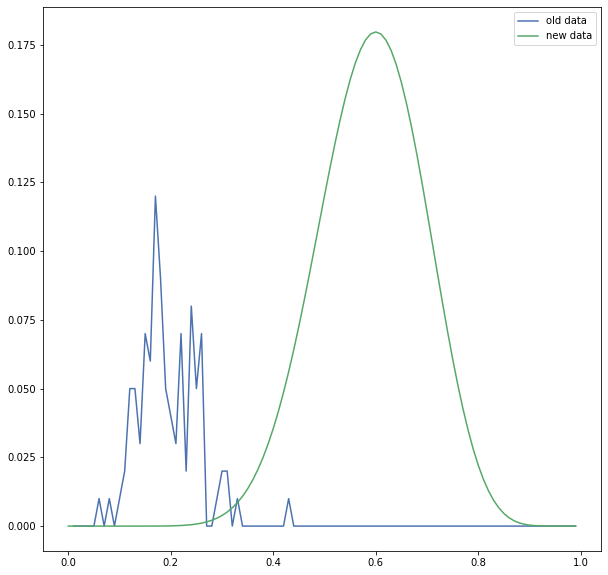

In [30]:
matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.pyplot.plot(from_zero_to_one[1:], normalised_historic_histogram, label='old data')
matplotlib.pyplot.plot(from_zero_to_one, distribution_ctr_evidence, label='new data')
matplotlib.pyplot.legend(loc='upper right')
matplotlib.pyplot.show()

## Finding distribution of mocked data

In "Mocking data" part of this notebook, I created (faked) my past experience about ads performance. Since I mocked it, I know how it's distributed - in real world, however I wouldn't know. Since that now I'll find the distribution of
this simulated past data. Having both distributions, I'll be able to continue with the process of changing my belief about ad efficiency:

In [31]:
historicData_mean = sum(past_click_through_rates) / len(past_click_through_rates)
historicData_variance = (sum([(x - historicData_mean)**2 for x in past_click_through_rates]) / (len(past_click_through_rates) - 1))
historicData_parameter_alpha = historicData_mean**2 * ((1-historicData_mean) / historicData_variance - (1 / historicData_mean))
historicData_parameter_beta = historicData_parameter_alpha * (1 / historicData_mean - 1)

print(f'Parameter alpha: {historicData_parameter_alpha:.4f}, parameter beta: {historicData_parameter_beta:.4f}')

Parameter alpha: 8.3479, parameter beta: 35.6792


To estimate the distribution parameters given the data, I've used parameter estimation method described on https://en.wikipedia.org/wiki/Beta_distribution#Two_unknown_parameters

If I used SciPy library for this:

In [32]:
pastData_parameters = beta.fit(past_click_through_rates, floc=0, fscale=1)
parameter_alpha, parameter_beta = pastData_parameters[0:2]

print(f'Parameter alpha: {parameter_alpha:.4f}, parameter beta: {parameter_beta:.4f}')

Parameter alpha: 8.4791, parameter beta: 36.2288


## Updating my posterior belief with MCMC

Knowing how are distributed the previous data and the new one, I want to know how much should I change my belief about my ad campaigns - how much the new evidence really matter. The tool just right for this task is Bayes Rule. <br>
<i>"In probability theory and statistics, Bayes’ theorem (alternatively Bayes’ law or Bayes' rule) describes the probability of an event, based on prior knowledge of conditions that might be related to the event."</i> - <a href="https://en.wikipedia.org/wiki/Bayes%27_theorem">Wikipedia</a> 

That's exactly what I want to know - the probability of an event of clicking the ad, based on prior knowledge of historic ad's data given some new evidence:

First, let me use predefined function `markovChain_metropolis` to generate a number of plausible values drawn from a probability distribution, which I'm unable to name and drawn samples directly from, but about which I know it describes my sound belief after observing ad performance and remembering the previous ad performance.<br>
The function uses Bayes Rule internally by randomly selecting samples from the given and known distributions (the old and the new ad data) and then checking if the new sample is more probable of being from the new (posterior) data set.<br>
The above is executed in lines:<br>
`probability_current = likelihood_current * prior_current` <br>
`probability_proposal = likelihood_proposal * prior_proposal` <br>
`accept = probability_proposal / probability_current` <br>
And what could be rephrased as `P(acceptance) = (P(newSample) * newLikelihood) / (P(oldSample) * oldLikelihood)`

In [33]:
iterations = 1000
propositions = markovChain_metropolis(iterations, nr_clicks, nr_impressions, historicData_parameter_alpha, historicData_parameter_beta)

From the generated data, let me count how many values falls into bins:

In [34]:
markovSamples_count, bins = np.histogram(propositions, bins=from_zero_to_one)

Finally, let me print a chart showing probability histogram for the old, the new data and changed belief about ad efficiency:

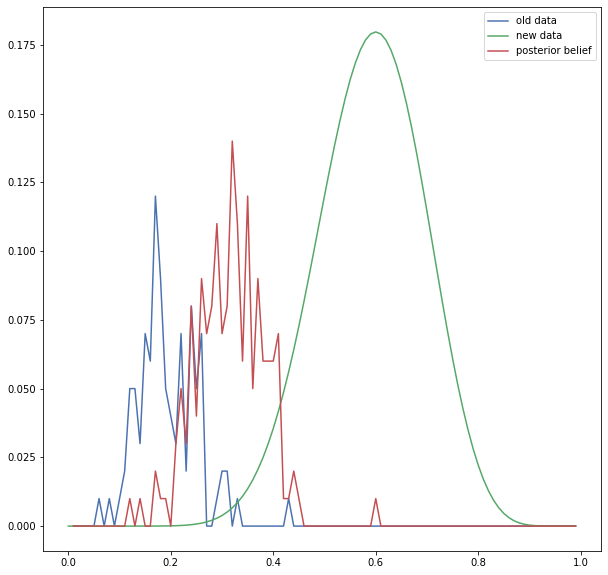

In [36]:
normalised_markovSamples_count = [float(x) / 100 for x in markovSamples_count] # normalising the histogram

matplotlib.pyplot.figure(figsize=(10, 10))
matplotlib.pyplot.plot(from_zero_to_one[1:], normalised_historic_histogram, label='old data')
matplotlib.pyplot.plot(from_zero_to_one, distribution_ctr_evidence, label='new data')
matplotlib.pyplot.plot(from_zero_to_one[1:], normalised_markovSamples_count, label='posterior belief')
matplotlib.pyplot.legend(loc='upper right')
matplotlib.pyplot.show()